## import libraries 

In [1]:
import glob
import pydicom
import pandas as pd
from matplotlib import pyplot as plt
from funcs import xml_reader
import numpy as np
import os
import scipy
import cv2
import read_inbreast as readin
import os
from matplotlib import pyplot as plt
import numpy as np
import time
import sys
import pickle

## functions

In [2]:
def get_images_path():
    paths = glob.glob(path+"/AllDICOMs/*.dcm")
    paths.sort()
    return paths

def separate_sets():
    images = get_images_path()
    with_masses = set()
    no_masses = set()

    for img in images:
        pat = os.path.basename(img).split("_")[0]
        if len(get_masses(pat))==0:
            no_masses.add(img)
        else:
            with_masses.add(img)

    return with_masses,no_masses

def get_xml_path():
    paths = glob.glob(path+"/AllXML/*.xml")
    paths.sort()
    return paths

def read_img(img_path):
    return pydicom.dcmread(img_path).pixel_array

def show_img(img):
    plt.imshow(img,cmap = "gray")

def read_info():
    df = pd.read_excel(path+"/INbreast.xls")
    return df

def has_mass(df,patient):
    return df.loc[df["File Name"] == patient].iloc[0]["Mass"]=="X"
### improve the conteast of iamge ---> CLAHE
clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))

def preprocessing(img,resize_factor=(1/24)):
    # img = cv2.resize(img, (0,0), fx=resize_factor,fy=resize_factor)
    cl1 = clahe.apply(img)
    cl1 = (cl1-np.min(cl1))/(np.max(cl1)-np.min(cl1))
    return cl1


def get_images_path():
    paths = glob.glob(path+"/AllDICOMs/*.dcm")
    paths.sort()
    return paths


def get_masses(pat,resize_factor=(1/24)):
    all_xmls = get_xml_path()
    masses = []
    xml = path+"/AllXML/"+pat+".xml"
    if xml in all_xmls:
            lesions = xml_reader.get_mask_points(xml)
            for row in (lesions):
                if row[2] in("R","C","M"):
                    masses.append([row[0].astype(int),
                                   row[1].astype(int),row[2]])
    return masses


def separate_sets():
    images = get_images_path()
    with_masses = set()
    no_masses = set()

    for img in images:
        pat = os.path.basename(img).split("_")[0]
        if len(get_masses(pat))==0:
            no_masses.add(img)
        else:
            with_masses.add(img)

    return with_masses,no_masses





## define the hyperparameters 

In [3]:

patch_size = 384
safe_padding = 40
inv_resize_factor = 12
resize_factor = float(1/inv_resize_factor)
jittering_vector = [-5,0,5]

half_patch_size = int(patch_size/2)
path = "/home/sshabani/projects/SDL/data/INbreast_Release_1.0"

In [4]:
## define healthy and abnormal images
with_masses,no_masses = separate_sets()

## abnormal patches

In [46]:
from tqdm import tqdm
patch_size = 384
half_patch_size = int(patch_size/2)
# set_ = with_masses
set_ = list(with_masses)
init_time = time.time()
print("Started taking patches from set","tr","(",len(set_),")","\n")
# PositivePatches = np.zeros([7172,128,128])
PositivePatches = []
i= 0
Part =0
Total=0
for image in tqdm(set_):
    # print(image)
    pat = os.path.basename(image).split("_")[0]
    img_arr_Before_resize = pydicom.dcmread(image).pixel_array
    # img_arr = readin.resize_image(img_arr)
    # print("size befoer the perprocessing:", img_arr_Before_resize.shape)
    img_arr = preprocessing(img_arr_Before_resize,resize_factor)
    # print("size after the perprocessing:", img_arr.shape)
    # print("img_arr.max(),img_arr.min()---------------",img_arr.max(),img_arr.min())

    masses = get_masses(pat,resize_factor)
    safe_zone = img_arr>0

    safe_zone = np.pad(safe_zone,safe_padding,"constant")
    img_arr = np.pad(img_arr,safe_padding,"symmetric")
    # print("after safe padding", img_arr.shape)
    # print(masses[0][0], masses[0][1], masses[0][2])

    if len(masses)>0:
        points = np.zeros((len(masses),2))

    counter=0
    for mass in masses:
        counter+=1
    ### Creating the patches
        # print('Mass:',mass)
        # print('Mass points:',mass[0][0],mass[0][1])
        # print('X:',mass[0][1]-half_patch_size,mass[0][1]+half_patch_size)
        # print('y:',mass[0][0]-half_patch_size,mass[0][0]+half_patch_size)
        positive_patch = img_arr[mass[0][1]-half_patch_size:mass[0][1]+half_patch_size
                                ,mass[0][0]-half_patch_size:mass[0][0]+half_patch_size]
        # print("positive_patch.shape:",positive_patch.shape)
        if(positive_patch.shape==(patch_size,patch_size)):
        #   PositivePatches.append(positive_patch)
          # Total +=1
          np.save('/home/sshabani/projects/SDL/data/preprocssed_data/abnormal/'+'1_'+str(i)+'.npy' ,positive_patch)
          i+=1

    # break

# PositivePatches_array = np.array(PositivePatches)  # Convert list of arrays to a NumPy array

# np.save('/home/sshabani/projects/SDL/data/preprocssed_data/'+'AbnormalPart_'+str(1)+'.npy',PositivePatches_array)



Started taking patches from set tr ( 343 ) 



100%|██████████| 343/343 [01:39<00:00,  3.43it/s]


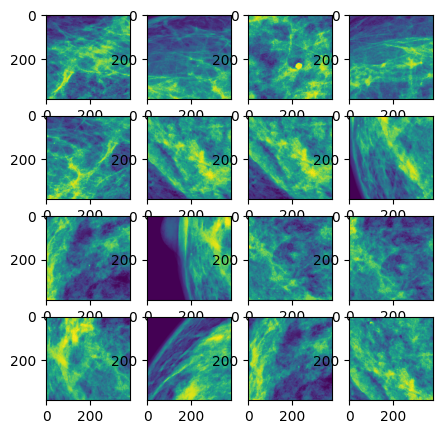

In [8]:
plt.figure(figsize=(5,5))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(PositivePatches_array[i+10,:,:])

## normal patches

## all

In [43]:
from tqdm import tqdm
patch_size = 384
half_patch_size = int(patch_size/2)
init_time = time.time()
counter_outer=0
set_ = list(no_masses)
print("Started taking patches from set","tr","(",len(set_),")","\n")

# image = with_masses[0]
Counsts= 2000
# negative_patches = np.zeros([Counsts,128,128])
negative_patches = []


image = set_[0]
for image in tqdm(set_):
    # print(image)
    pat = os.path.basename(image).split("_")[0]
    img_arr_Before_resize = pydicom.dcmread(image).pixel_array
    # pydicom.dcmread(image).pixel_array
    #img_arr = readin.resize_image(img_arr)
    img_arr = preprocessing(img_arr_Before_resize,resize_factor)

    for i in range(half_patch_size,img_arr.shape[0]-half_patch_size,half_patch_size):
        for j in range(half_patch_size,img_arr.shape[1]-half_patch_size,half_patch_size):
            # print(img_arr[i-half_patch_size:i+half_patch_size,j-half_patch_size:j+half_patch_size].shape)
            negative_patches.append(img_arr[i-half_patch_size:i+half_patch_size,j-half_patch_size:j+half_patch_size])

print("len of negative_patches ", len(negative_patches))

### removing zero patches
negative_patches_list= []
## set a threshold n the binary mask 
for i in range(len(negative_patches)):
    sample = negative_patches[i].copy()
    sample_binary = (sample > 0.001).astype(int)
    if (np.sum(sample_binary)> (0.6*(sample_binary.shape[0]*sample_binary.shape[1]))):
        # negative_patches_list.append(negative_patches[i])
        np.save('/home/sshabani/projects/SDL/data/preprocssed_data/normal/all/'+'0_'+str(i)+'.npy' ,negative_patches[i])

# print("after romoving free spaces",len(negative_patches_list))

# ## convert list to numpyarray 
# negative_patches_list_np = np.array(negative_patches_list)

# patches_list= []
# for i in range(len(negative_patches_list)):
#     if(negative_patches_list[i].sum()<50000): ## negative_patches[i].sum()<40000 and 
#         patches_list.append(negative_patches_list[i])
#         np.save('/home/sshabani/projects/SDL/data/preprocssed_data/normal/all/'+'0_'+i+'.npy' ,negative_patches_list[i])


# print("after romoving high intensity",len(patches_list))
# ## convert list to numpyarray 
# patches_list_np = np.array(patches_list)  # Convert list of arrays to a NumPy array

# ## save the data 
# np.save('/home/sshabani/projects/SDL/data/preprocssed_data/'+'normalPart_all.npy',negative_patches_list_np)





Started taking patches from set tr ( 67 ) 



100%|██████████| 67/67 [00:04<00:00, 15.87it/s]


len of negative_patches  14144


## medium

In [44]:
from tqdm import tqdm
patch_size = 384
half_patch_size = int(patch_size/2)
init_time = time.time()
counter_outer=0
set_ = list(no_masses)
print("Started taking patches from set","tr","(",len(set_),")","\n")

# image = with_masses[0]
Counsts= 2000
# negative_patches = np.zeros([Counsts,128,128])
negative_patches = []


image = set_[0]
for image in tqdm(set_):
    # print(image)
    pat = os.path.basename(image).split("_")[0]
    img_arr_Before_resize = pydicom.dcmread(image).pixel_array
    # pydicom.dcmread(image).pixel_array
    #img_arr = readin.resize_image(img_arr)
    img_arr = preprocessing(img_arr_Before_resize,resize_factor)

    for i in range(half_patch_size,img_arr.shape[0]-half_patch_size,half_patch_size):
        for j in range(half_patch_size,img_arr.shape[1]-half_patch_size,half_patch_size):
            # print(img_arr[i-half_patch_size:i+half_patch_size,j-half_patch_size:j+half_patch_size].shape)
            negative_patches.append(img_arr[i-half_patch_size:i+half_patch_size,j-half_patch_size:j+half_patch_size])

print("len of negative_patches ", len(negative_patches))

### removing zero patches
negative_patches_list= []
## set a threshold n the binary mask 
for i in range(len(negative_patches)):
    sample = negative_patches[i].copy()
    sample_binary = (sample > 0.001).astype(int)
    if (np.sum(sample_binary)> (0.6*(sample_binary.shape[0]*sample_binary.shape[1]))):
        negative_patches_list.append(negative_patches[i])

print("after romoving free spaces",len(negative_patches_list))

## convert list to numpyarray 
negative_patches_list_np = np.array(negative_patches_list)

patches_list= []
for i in range(len(negative_patches_list)):
    if(negative_patches_list[i].sum()<50000): ## negative_patches[i].sum()<40000 and 
        # patches_list.append(negative_patches_list[i])
        np.save('/home/sshabani/projects/SDL/data/preprocssed_data/normal/medium/'+'0_'+str(i)+'.npy' ,negative_patches_list[i])




# print("after romoving high intensity",len(patches_list))
# ## convert list to numpyarray 
# patches_list_np = np.array(patches_list)  # Convert list of arrays to a NumPy array

# ## save the data 
# np.save('/home/sshabani/projects/SDL/data/preprocssed_data/'+'normalPart_medium.npy',patches_list_np)


#fewer =  uppper band 30000 ----> sample 1200
#medium =  uppper band 40000 ---> 2079 sample
#all =  without  uppper band---> 3682 sample


Started taking patches from set tr ( 67 ) 



100%|██████████| 67/67 [00:04<00:00, 16.10it/s]


len of negative_patches  14144
after romoving free spaces 4154


## low

In [45]:
from tqdm import tqdm
patch_size = 384
half_patch_size = int(patch_size/2)
init_time = time.time()
counter_outer=0
set_ = list(no_masses)
print("Started taking patches from set","tr","(",len(set_),")","\n")

# image = with_masses[0]
Counsts= 2000
# negative_patches = np.zeros([Counsts,128,128])
negative_patches = []


image = set_[0]
for image in tqdm(set_):
    # print(image)
    pat = os.path.basename(image).split("_")[0]
    img_arr_Before_resize = pydicom.dcmread(image).pixel_array
    # pydicom.dcmread(image).pixel_array
    #img_arr = readin.resize_image(img_arr)
    img_arr = preprocessing(img_arr_Before_resize,resize_factor)

    for i in range(half_patch_size,img_arr.shape[0]-half_patch_size,half_patch_size):
        for j in range(half_patch_size,img_arr.shape[1]-half_patch_size,half_patch_size):
            # print(img_arr[i-half_patch_size:i+half_patch_size,j-half_patch_size:j+half_patch_size].shape)
            negative_patches.append(img_arr[i-half_patch_size:i+half_patch_size,j-half_patch_size:j+half_patch_size])

print("len of negative_patches ", len(negative_patches))

### removing zero patches
negative_patches_list= []
## set a threshold n the binary mask 
for i in range(len(negative_patches)):
    sample = negative_patches[i].copy()
    sample_binary = (sample > 0.001).astype(int)
    if (np.sum(sample_binary)> (0.6*(sample_binary.shape[0]*sample_binary.shape[1]))):
        negative_patches_list.append(negative_patches[i])

print("after romoving free spaces",len(negative_patches_list))

## convert list to numpyarray 
negative_patches_list_np = np.array(negative_patches_list)

patches_list= []
for i in range(len(negative_patches_list)):
    if(negative_patches_list[i].sum()<40000): ## negative_patches[i].sum()<40000 and 
        # patches_list.append(negative_patches_list[i])
        np.save('/home/sshabani/projects/SDL/data/preprocssed_data/normal/low/'+'0_'+str(i)+'.npy' ,negative_patches_list[i])



# print("after romoving high intensity",len(patches_list))
# ## convert list to numpyarray 
# patches_list_np = np.array(patches_list)  # Convert list of arrays to a NumPy array

# ## save the data 
# np.save('/home/sshabani/projects/SDL/data/preprocssed_data/'+'normalPart_low.npy',patches_list_np)


#fewer =  uppper band 30000 ----> sample 1200
#medium =  uppper band 40000 ---> 2079 sample
#all =  without  uppper band---> 3682 sample


Started taking patches from set tr ( 67 ) 



100%|██████████| 67/67 [00:04<00:00, 16.02it/s]


len of negative_patches  14144
after romoving free spaces 4154


3682


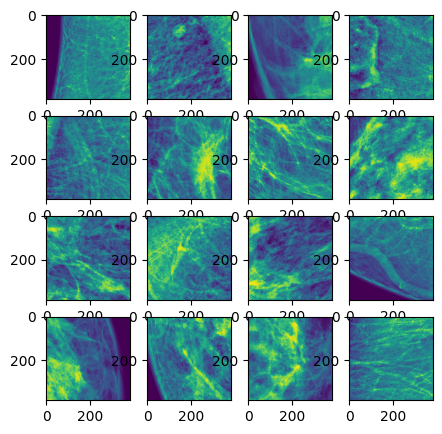

In [15]:
plt.figure(figsize=(5,5))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(negative_patches_list[i*25])

print(len( negative_patches_list))

2256


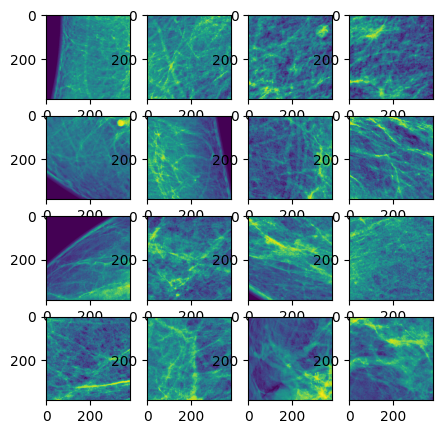

In [20]:
plt.figure(figsize=(5,5))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(patches_list[i*10])

print(len( patches_list))

In [14]:
len(negative_patches)

14144

## load and plot 

1391


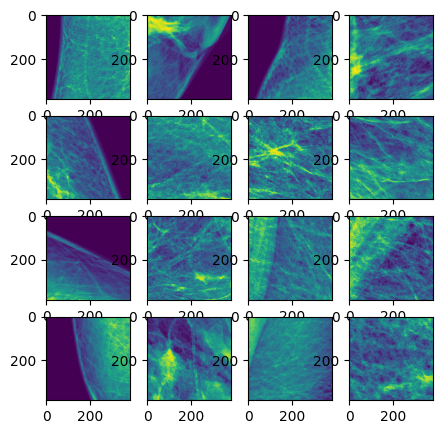

In [38]:
data = np.load("/home/sshabani/projects/SDL/data/preprocssed_data/normalPart_low.npy")

plt.figure(figsize=(5,5))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i*25,:,:])

print(len(data))

2483


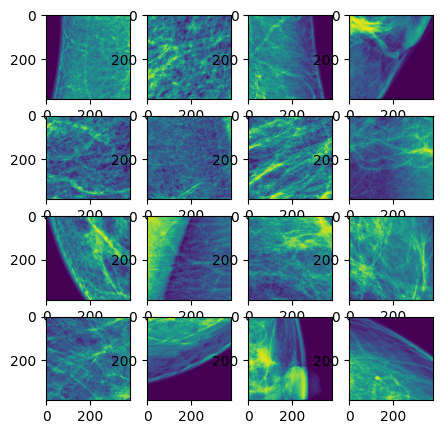

In [40]:
data = np.load("/home/sshabani/projects/SDL/data/preprocssed_data/normalPart_medium.npy")

plt.figure(figsize=(5,5))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i*25,:,:])
    
print(len(data))

4154


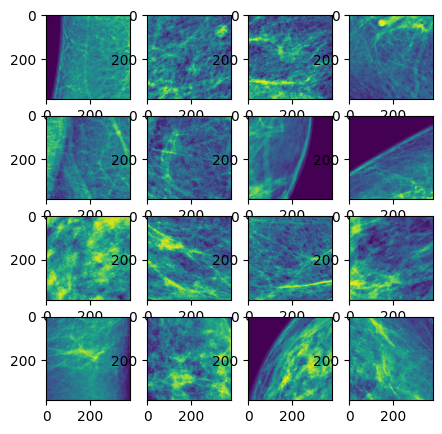

In [41]:
data = np.load("/home/sshabani/projects/SDL/data/preprocssed_data/normalPart_all.npy")

plt.figure(figsize=(5,5))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i*25,:,:])

print(len(data))

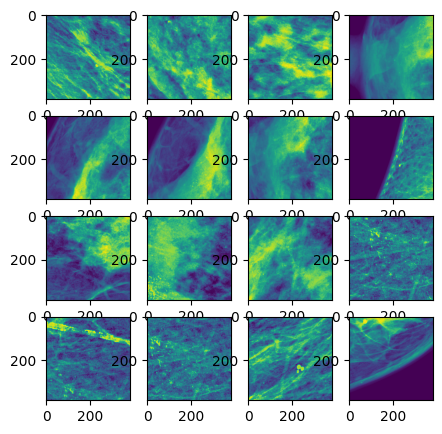

In [29]:
medium = np.load("/home/sshabani/projects/SDL/data/preprocssed_data/AbnormalPart_1.npy")

plt.figure(figsize=(5,5))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(medium[i*25,:,:])


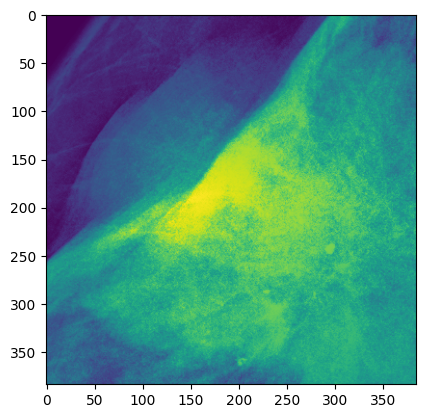

In [48]:

data = np.load("/home/sshabani/projects/SDL/data/preprocssed_data/abnormal/1_600.npy")

plt.imshow(data)

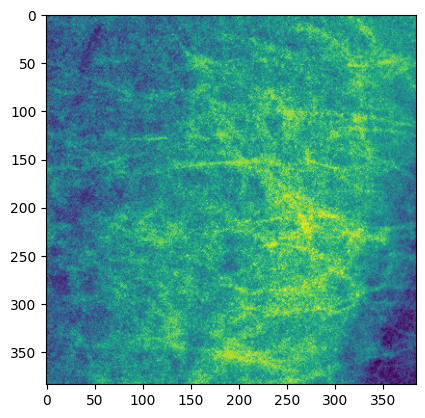

In [52]:

data = np.load("/home/sshabani/projects/SDL/data/preprocssed_data/normal/all/0_241.npy")

plt.imshow(data)